<a href="https://colab.research.google.com/github/michelup/SDA_FINAL_PROJECT/blob/main/SDA_FINAL_PROJECT_Pokemons_DenseNET121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import json
import requests
import kagglehub
import os
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.src.applications.densenet import DenseNet121, preprocess_input
from keras.src.models import Sequential
from keras.src.utils import image_dataset_from_directory
from keras import layers, models
from keras.src.layers import Dense, Dropout
import matplotlib.pyplot as plt



from PIL import Image, ImageOps

from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from keras.preprocessing import image_dataset_from_directory
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras.layers import Input, Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.models import Model, Sequential



In [4]:
#import datasetu
import kagglehub

path = kagglehub.dataset_download("rogerkoala/first-gen-pokemon")


In [5]:
#vypsani slozek

os.listdir()

['.config', 'sample_data']

In [6]:
# ulozeni cesty k datum

data_dir = f"{path}{os.sep}dataset"


In [7]:

# Nahrani training and validacniho  datasetu

train_dataset = image_dataset_from_directory(
    data_dir + os.sep + "train",
    image_size=(224,224 ),  # Resize images - model pouziva defaultni rozliseni 224x224
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    data_dir + os.sep + "test",
    image_size=(224,224),
    batch_size=32
)


Found 2249 files belonging to 151 classes.
Found 840 files belonging to 151 classes.


In [8]:
#ulozeni nazvu trid pokemonu

class_names = test_dataset.class_names #seznam tříd/názvů jednotlivých kategorií, odvozenych z názvů složek při načítání datasetu

In [9]:
#vypsani trid/jmen pokemonu
class_names


['Abra',
 'Aerodactyl',
 'Alakazam',
 'Arbok',
 'Arcanine',
 'Articuno',
 'Beedrill',
 'Bellsprout',
 'Blastoise',
 'Bulbasaur',
 'Butterfree',
 'Caterpie',
 'Chansey',
 'Charizard',
 'Charmander',
 'Charmeleon',
 'Clefable',
 'Clefairy',
 'Cloyster',
 'Cubone',
 'Dewgong',
 'Diglett',
 'Ditto',
 'Dodrio',
 'Doduo',
 'Dragonair',
 'Dragonite',
 'Dratini',
 'Drowzee',
 'Dugtrio',
 'Eevee',
 'Ekans',
 'Electabuzz',
 'Electrode',
 'Exeggcute',
 'Exeggutor',
 'Farfetch',
 'Fearow',
 'Flareon',
 'Gastly',
 'Gengar',
 'Geodude',
 'Gloom',
 'Golbat',
 'Goldeen',
 'Golduck',
 'Golem',
 'Graveler',
 'Grimer',
 'Growlithe',
 'Gyarados',
 'Haunter',
 'Hitmonchan',
 'Hitmonlee',
 'Horsea',
 'Hypno',
 'Ivysaur',
 'Jigglypuff',
 'Jolteon',
 'Jynx',
 'Kabuto',
 'Kabutops',
 'Kadabra',
 'Kakuna',
 'Kangaskhan',
 'Kingler',
 'Koffing',
 'Krabby',
 'Lapras',
 'Lickitung',
 'Machamp',
 'Machoke',
 'Machop',
 'Magikarp',
 'Magmar',
 'Magnemite',
 'Magneton',
 'Mankey',
 'Marowak',
 'Meowth',
 'Metapod',
 

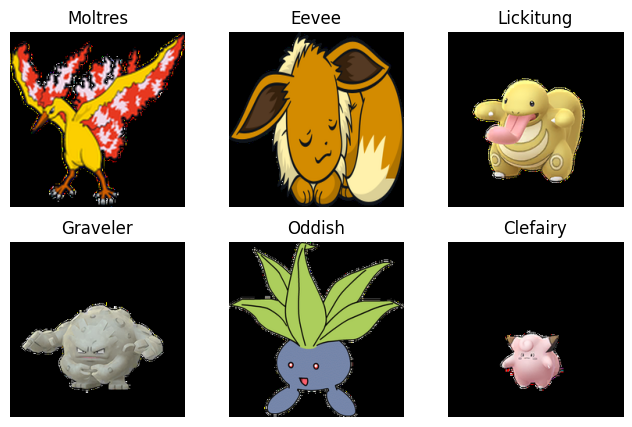

In [10]:
# Zobrazeni nekolika pokemonu s nazvy pro kontrolu

plt.figure(figsize=(8, 5))
for images, labels in train_dataset.take(1):  # Vezme 1 batch
    for i in range(6):  # zobrazi prvnich 6 obrazku
        plt.subplot(2, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i].numpy())]) #labels - vezme i-tý label z dávky(Tensoru), Numpy() převede tensor na NumPy pole
        plt.axis("off")
plt.show()

In [11]:
#predzpracovani obrazku v train a test datasetu pomoci preprocess input - Funkce na předzpracování vstupního obrázku (např. změna velikosti, normalizace apod.)

train_dataset = train_dataset.map(lambda x, y: (preprocess_input(x), tf.one_hot(y, depth=151)))
test_dataset = test_dataset.map(lambda x, y: (preprocess_input(x), tf.one_hot(y, depth=151)))

In [12]:
# obrazový klasifikační model v Kerasu pomocí přístupu zvaného transfer learning  s předtrénovaným modelem DenseNet121
# model využívá  předtrénovaný základ DenseNet121 pro extrakci vizuálních rysů a staví na něm vlastní klasifikátor pro nový úkol s 151 kategoriemi/pokemony

from tensorflow.keras import Sequential, layers
from tensorflow.keras.applications import DenseNet121


base_model = DenseNet121(
    include_top=False,   # Vynechá původní klasifikační hlavu (1000 tříd z ImageNetu)
    weights='imagenet',  # Nahraje váhy natrénované na ImageNetu — skvělé pro transfer learning
    input_shape=(224, 224, 3) #Vstupní obrázky: RGB, rozlišení 224×224
) #Výsledek: model, který dokáže extrahovat vizuální rysy z obrázku, ale zatím neklasifikuje Pokémony


#FREEZE - zmrazeni vah  - pouzito pro testovaci ucely, presnost klesla na cca 92%,ale cas trenovani byl 1/3 trenovaciho casu bez freezu - vhodne pro velke datasety
#base_model.trainable = False

model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),   #Průměruje výstupy z poslední konvoluční vrstvy → zmenší dimenze
    layers.Dense(128, activation='relu'),  #Naučí se kombinovat extrahované znaky do 128 prvků
    layers.Dropout(0.5), #Regularizace – náhodně „vypíná“ neurony při trénování, aby se model nepřeučil
    layers.Dense(151, activation='softmax')  #Výstupní klasifikátor – pro každého Pokémona vrátí pravděpodobnost
])

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
#Kompilace modelu

model.compile(
    optimizer="adam", #Používá Adam optimizer – adaptivní a rychlý optimalizátor, který upravuje váhy modelu během tréninku.
    loss='categorical_crossentropy', #Funkce ztráty (loss) měří, jak moc se predikce liší od správných odpovědí. categorical_crossentropy se používá pro vícetřídovou klasifikaci s one-hot vektory
    metrics=['accuracy']  #Určuje metriky pro sledování výkonnosti modelu — přesnost ukazuje procento správně klasifikovaných obrázků

)

model.summary()   #vypise tabulku architektury modelu   - Poradi vrstev/Vystupni tvar - pocet neuronu/pocty trenovatelnych parametru(vah)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 151)            │        19,479 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,188,183 (27.42 MB)

 Trainable params: 7,104,535 (27.10 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [14]:
#pripojeni google drive

from google.colab import drive
drive.mount('/content/drive')




Mounted at /content/drive


In [15]:
#uklada checkpoints/vahy na muj drive, pokud bych ukladal jen do kolabu, tak v pripade padu bych o vysledky modelu prisel

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/SDA/Final_project/soubor_densenet121.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)



In [16]:
#trenovani modelu

epoch_val = 100

history=model.fit(
    train_dataset,  #uci se na trenovacich datech
    validation_data=test_dataset, # definice validacnich dat
    epochs=epoch_val, #nacteni poctu epoch - kolikrat model projde cely dataset
    callbacks=[checkpoint_callback]  #ukladani vah

    )

Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0403 - loss: 5.0374   
Epoch 1: val_accuracy improved from -inf to 0.02976, saving model to /content/drive/MyDrive/SDA/Final_project/soubor_densenet121.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 309s 2s/step - accuracy: 0.0405 - loss: 5.0348 - val_accuracy: 0.0298 - val_loss: 5.7161
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.0927 - loss: 4.4145
Epoch 2: val_accuracy improved from 0.02976 to 0.04286, saving model to /content/drive/MyDrive/SDA/Final_project/soubor_densenet121.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 24s 330ms/step - accuracy: 0.0930 - loss: 4.4125 - val_accuracy: 0.0429 - val_loss: 13.8920
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.1739 - loss: 3.7684
Epoch 3: val_accuracy improved from 0.04286 to 0.21190, saving model to /content/drive/MyDrive/SDA/Final_project/soubor_densenet121.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 41s 329ms/step - accuracy: 0.1745 - loss: 3.7651 - val_accuracy: 0

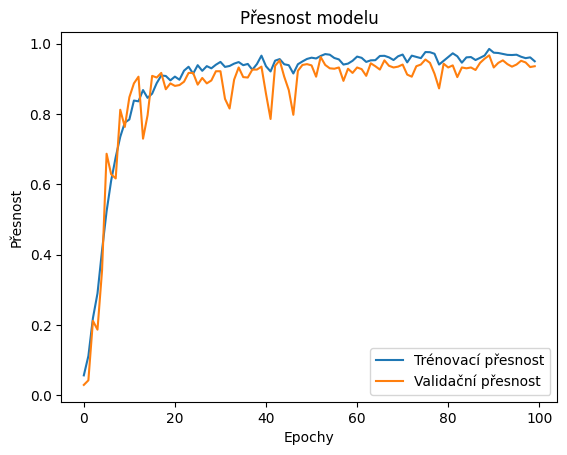

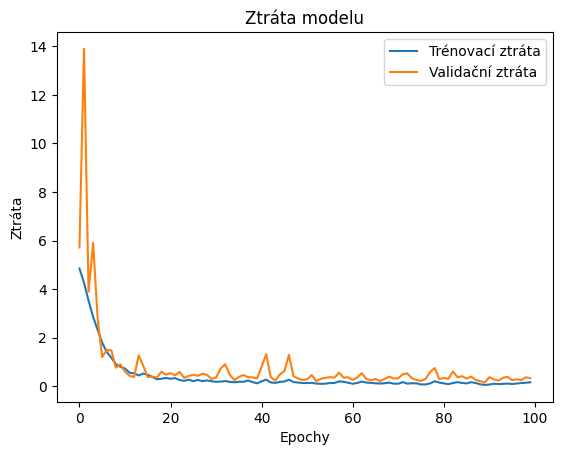

In [17]:

# Graficke znazorneni presnosti a ztraty

# Přesnost
plt.plot(history.history['accuracy'], label='Trénovací přesnost')
plt.plot(history.history['val_accuracy'], label='Validační přesnost')
plt.legend()
plt.title('Přesnost modelu')
plt.xlabel('Epochy')
plt.ylabel('Přesnost')
plt.show()

# Ztráta
plt.plot(history.history['loss'], label='Trénovací ztráta')
plt.plot(history.history['val_loss'], label='Validační ztráta')
plt.legend()
plt.title('Ztráta modelu')
plt.xlabel('Epochy')
plt.ylabel('Ztráta')
plt.show()

In [18]:
#kód slouží ke sběru skutečných a predikovaných tříd z testovací sady, abys mohl později vyhodnotit výkon svého modelu — třeba pomocí confusion_matrix, classification_report nebo grafu přesnosti.


# prázdné seznamy, kam se budou ukládat skutečné a predikované třídy pro každý batch z test_dataset.
y_true = []
y_pred = []

# Iteruje přes jednotlivé dávky obrázků (images) a odpovídající one-hot štítky (labels) z testovacího datasetu.

for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))         # skutečné třídy
    y_pred.extend(np.argmax(preds, axis=1))                   # predikované třídy


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

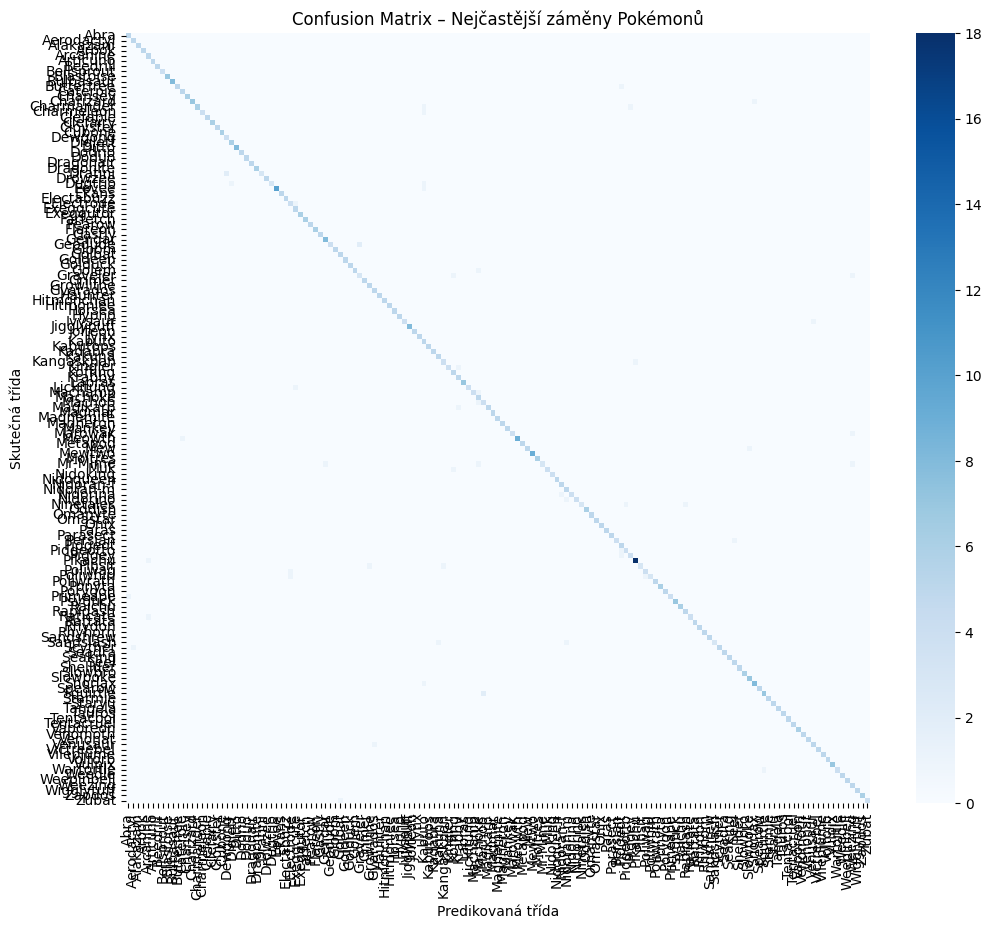

In [19]:
#vytvoreni confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predikovaná třída')
plt.ylabel('Skutečná třída')
plt.title('Confusion Matrix – Nejčastější záměny Pokémonů')
plt.show()


In [20]:
#TOP 10 nejcastejsich zamen - Confusion matrix v TABULCE
import pandas as pd

cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
most_confused = cm_df.stack().sort_values(ascending=False)
most_confused = most_confused[most_confused.index.get_level_values(0) != most_confused.index.get_level_values(1)]
print("Top 10 nejčastějších záměn:")
print(most_confused.head(10))

Top 10 nejčastějších záměn:
Dratini     Dewgong      2
Geodude     Graveler     2
Squirtle    Machop       2
Ninetales   Pidgeotto    1
Charmeleon  Kabuto       1
Lickitung   Exeggcute    1
Mr-Mime     Machoke      1
Sandslash   Kakuna       1
Magikarp    Krabby       1
Venusaur    Gyarados     1
dtype: int64


In [21]:
# Zobraz top3 záměn jako dvojice obrázk

import random
import matplotlib.pyplot as plt

def show_comparison(wrong_img, correct_img, true_label, pred_label):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))  #- Vytvoří obrázek (fig) s 1 řádkem a 2 sloupci podgrafů (axes) vedle sebe.


    for ax, img, title in zip(axes, [wrong_img, correct_img], [f"Predikce: {pred_label}", f"Správně: {true_label}"]):
        if img.dtype != np.uint8:
            img = (img - np.min(img)) / (np.max(img) - np.min(img))
            img = (img * 255).astype("uint8")
        ax.imshow(img)
        ax.set_title(title, fontsize=10)
        ax.axis("off")

    plt.tight_layout()  # Upraví rozvržení grafu, aby se prvky nepřekrývaly

    plt.show()

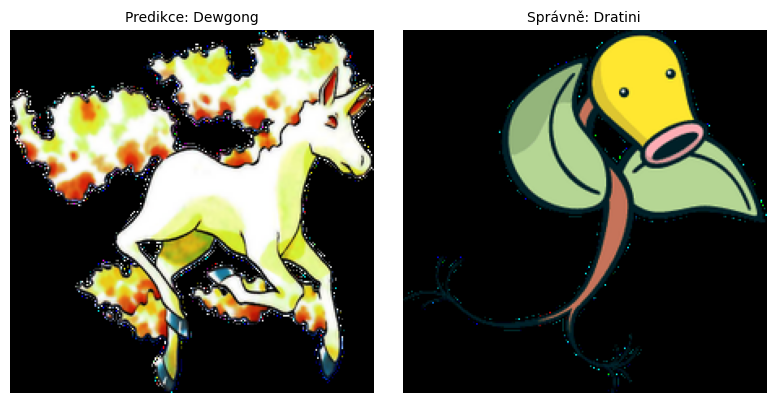

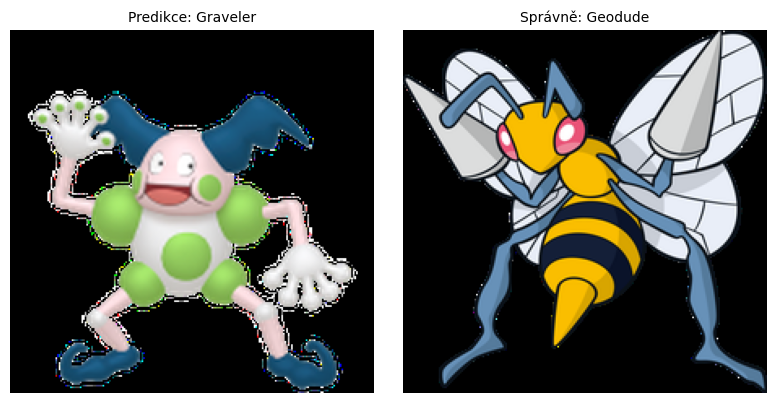

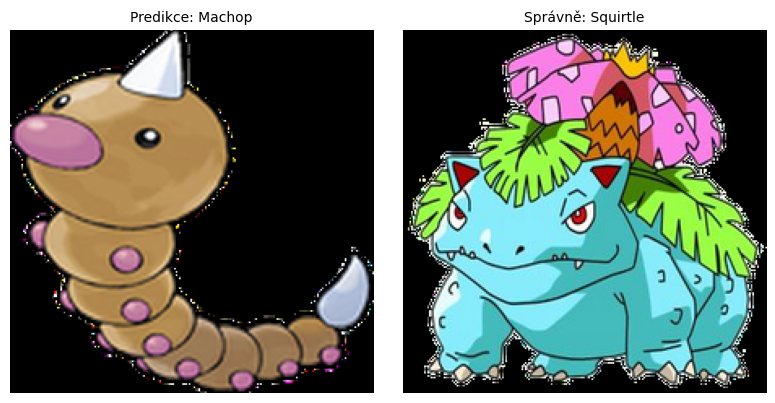

In [22]:
#pokracovani kodu k zobrazeni 3 TOP zamen

shown = 0

# Collect images from the test dataset before preprocessing
images_list = []
for images, labels in test_dataset.unbatch():
    images_list.append(images.numpy())


for (true_cls, pred_cls), count in most_confused.items():
    true_idx = class_names.index(true_cls)
    pred_idx = class_names.index(pred_cls)

    # Najdi špatně klasifikovaný obrázek
    wrong_img = None
    for i in range(len(y_true)):
        if y_true[i] == true_idx and y_pred[i] == pred_idx:
            wrong_img = images_list[i]
            break

    # Najdi správně klasifikovaný obrázek z predikované třídy
    correct_img = None
    for i in range(len(y_true)):
        if y_true[i] == pred_idx and y_pred[i] == pred_idx:
            correct_img = images_list[i]
            break

    # Pokud máme obě varianty, zobrazíme je
    if wrong_img is not None and correct_img is not None:
        show_comparison(wrong_img, correct_img, true_cls, pred_cls)
        shown += 1

    if shown >= 3:
        break